# Predict media from taxa

In [30]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

In [31]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), low_memory=False)

data_df = data_df.dropna(subset='component_id', how='any')
data_df['component_id'] = data_df['component_id'].astype(int)

data_df = data_df[["taxon_id", "media_id", "component_id"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="component_id",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df.head()

component_id,taxon_id,media_id,4,18,33,37,46,47,56,60,...,430,497,498,506,616,688,754,1353,1359,1819
0,100,J349,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002526,J22,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003997,J1052,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005039,J845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [32]:
TARGET_VAR = "media_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [34]:
# Define the pipeline
reducer = umap.UMAP(
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_neighbors=5,
        n_components=5,
        min_dist=0.4
    )

reduced = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(reduced, columns=[f"Component {i+1}" for i in range(reduced.shape[1])])

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5
0,6.200758,1.830586,3.872833,4.888375,0.485454
1,6.163312,1.769454,4.145391,4.558549,0.301123
2,6.380999,1.464379,4.228890,4.755553,0.573985
3,6.307285,1.939979,4.007106,4.693278,0.333481
4,5.947842,1.962967,18.125523,-1.007968,1.799312


### Clustering

In [35]:
cluster = KMeans(
    n_clusters=10,
    random_state=RANDOM_SEED
)
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.



In [36]:
# Add ID columns
reduced_df[["taxon_id", "media_id"]] = \
    data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster,taxon_id,media_id
0,6.200758,1.830586,3.872833,4.888375,0.485454,1,156648,J50
1,6.163312,1.769454,4.145391,4.558549,0.301123,1,1304888,1526d
2,6.380999,1.464379,4.228890,4.755553,0.573985,1,2690208,141a
3,6.307285,1.939979,4.007106,4.693278,0.333481,1,1868421,J475
4,5.947842,1.962967,18.125523,-1.007968,1.799312,9,686223,J586
...,...,...,...,...,...,...,...,...
2562,8.052056,8.447831,-6.063531,2.869783,4.926891,0,1076594,J25
2563,12.522406,2.782177,-7.470769,7.436082,6.150905,0,679260,514c
2564,8.080864,4.051548,6.595332,4.838126,2.018702,1,323423,830c
2565,7.925502,4.040138,6.602787,4.841563,1.975971,1,317019,J475


In [37]:
reduced_df.to_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"), index=False)

#### Visualize the results

In [38]:
# Plot the training points
fig = px.scatter(
    data_frame = reduced_df,
    x = "Component 1",
    y = "Component 2",
    color = "Cluster",
    hover_data = ["taxon_id", "media_id"],
    opacity = 0.3
) 

fig.update_layout(
    title="Media Clusters",
    template="plotly_white"
)

fig.show()

#### Create new column from clusters

In [39]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([1, 1, 1, ..., 1, 1, 1])

### Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Metrics

In [41]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00       331
           2       1.00      1.00      1.00        25
           3       1.00      0.97      0.99        37
           4       1.00      1.00      1.00        95
           5       0.94      1.00      0.97        17
           6       1.00      1.00      1.00        31
           7       1.00      0.97      0.98        30
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        23

    accuracy                           1.00       642
   macro avg       0.99      0.99      0.99       642
weighted avg       1.00      1.00      1.00       642



In [42]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 1.0


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [44]:
# Binarize classes
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_train_bin.shape[1]

In [45]:
# OvR classification
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, y_train_bin)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True))

In [46]:
# Predict probabilities
y_score = classifier.decision_function(X_test)

In [47]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Example unique classes across train and test sets
all_classes = np.unique(np.concatenate([y_train, y_test]))  # 96 classes
test_classes = np.unique(y_test)  # 6 classes

# Find the indices of test classes in the full set of classes
relevant_indices = [np.where(all_classes == cls)[0][0] for cls in test_classes]

# Ensure the binarized test set only includes the test classes
y_test_bin = label_binarize(y_test, classes=test_classes)

# Subset y_score to the relevant indices (only the columns corresponding to the test classes)
y_score_subset = y_score[:, relevant_indices]

# Now, calculate ROC curves for each relevant class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):  # 6 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_subset[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, print or plot the ROC curves here


In [48]:
print(f"y_test_bin shape: {y_test_bin.shape}")  # Expected shape: (n_samples, 6)
print(f"y_score shape: {y_score.shape}")        # Expected shape: (n_samples, 96)

# Check that the number of classes in test matches the number you are evaluating
assert y_test_bin.shape[1] == len(relevant_indices), "Mismatch between test classes and relevant predictions!"

y_test_bin shape: (642, 10)
y_score shape: (642, 10)


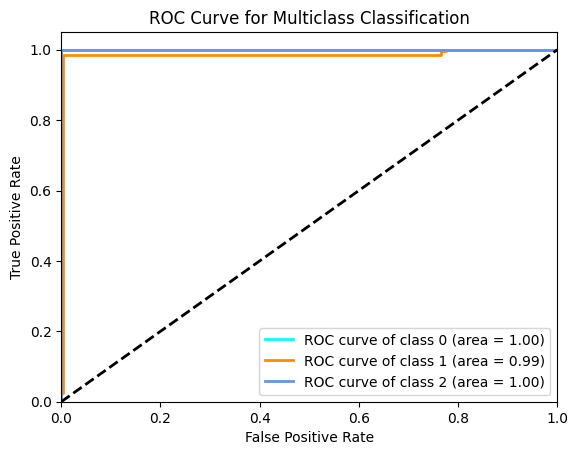

In [49]:
# Plot
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()